#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

 # Ensembles de caractéristiques

 **Objectif d'apprentissage :** Créer un ensemble de caractéristiques minimal offrant des performances identiques à un ensemble plus complexe

 Jusqu'à présent, toutes les caractéristiques ont été intégrées dans le modèle. Cependant, un modèle qui contient moins de caractéristiques utilise moins de ressources et s'avère plus facile à gérer. Voyons s'il est possible de construire un modèle basé sur un ensemble minimal de caractéristiques immobilières, mais offrant les mêmes performances qu'un modèle intégrant toutes les caractéristiques de l'ensemble de données.

 ## Configuration

Une fois encore, vous allez commencer par charger et préparer les données sur l'immobilier en Californie.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [4]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.5,28.6,2652.4,540.1,1433.9,502.2,3.9,2.0
std,2.1,2.0,12.6,2173.1,421.0,1160.6,384.3,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1472.8,298.0,793.0,283.0,2.6,1.5
50%,34.2,-118.5,29.0,2136.0,433.0,1166.0,408.0,3.6,1.9
75%,37.7,-118.0,37.0,3162.2,651.0,1727.2,608.0,4.8,2.3
max,42.0,-114.3,52.0,32627.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.7,-119.6,28.6,2622.6,537.7,1419.1,498.9,3.9,2.0
std,2.1,2.0,12.6,2196.4,422.8,1116.8,385.0,1.9,1.0
min,32.6,-124.2,1.0,15.0,3.0,9.0,5.0,0.5,0.1
25%,33.9,-121.8,18.0,1428.8,291.0,780.8,274.0,2.5,1.5
50%,34.3,-118.5,28.5,2107.5,435.0,1168.0,410.0,3.5,1.9
75%,37.7,-118.0,37.0,3123.2,643.2,1707.8,598.0,4.7,2.3
max,42.0,-114.5,52.0,37937.0,5471.0,16122.0,5189.0,15.0,27.1


Training targets summary:


,median_house_value
count,12000.0
mean,207.8
std,116.3
min,15.0
25%,120.0
50%,180.8
75%,265.1
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.1
std,115.1
min,15.0
25%,118.8
50%,179.2
75%,264.6
max,500.0


 ## Tâche 1 : Élaborer un ensemble de caractéristiques de bonne qualité

**Quelles performances peut-on obtenir avec simplement 2 ou 3 caractéristiques ?**

Une **matrice de corrélation** affiche des corrélations par paire, dans lesquelles chaque caractéristique est comparée à la cible, ainsi qu'aux autres caractéristiques.

Dans le cas présent, la corrélation est définie comme le [Coefficient de corrélation de Pearson](https://fr.wikipedia.org/wiki/Corrélation_(statistiques)#Coefficient_de_corrélation_linéaire_de_Bravais-Pearson). Vous ne devez pas nécessairement comprendre tous les détails mathématiques pour effectuer cet exercice.

La signification des valeurs de corrélation est la suivante :

  * `-1.0` : corrélation négative parfaite
  * `0.0` : pas de corrélation
  * `1.0` : corrélation positive parfaite

In [5]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["median_house_value"]

correlation_dataframe.corr()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.1,-0.1
longitude,-0.9,1.0,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.1,-0.0
housing_median_age,0.0,-0.1,1.0,-0.4,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.0,-0.4,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.0,0.0
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,-0.0,-0.1,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,-0.0,0.0,1.0,0.2,0.7
rooms_per_person,0.1,-0.1,-0.1,0.1,0.0,-0.1,-0.0,0.2,1.0,0.2
target,-0.1,-0.0,0.1,0.1,0.0,-0.0,0.1,0.7,0.2,1.0


 Idéalement, les caractéristiques devraient entretenir une forte corrélation avec la cible.

Il serait également souhaitable qu'elles ne soient pas aussi fortement corrélées les unes avec les autres, afin qu'elles ajoutent des informations indépendantes.

Utilisez ces informations pour essayer de supprimer des caractéristiques. Vous pouvez également essayer de créer d'autres caractéristiques synthétiques, telles que des ratios de deux caractéristiques brutes.

Pour plus de facilité, nous avons inclus le code d'apprentissage de l'exercice précédent.

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

 Vous allez maintenant consacrer cinq minutes à la recherche d'un ensemble satisfaisant de caractéristiques et de paramètres d'apprentissage. Pour rappel, les paramètres d'apprentissage peuvent être différents suivant les caractéristiques.

Training model...
RMSE (on training data):
  period 00 : 230.39
  period 01 : 222.72
  period 02 : 215.14
  period 03 : 207.68
  period 04 : 200.34
  period 05 : 193.15
  period 06 : 186.10
  period 07 : 179.23
  period 08 : 172.56
  period 09 : 166.10
Model training finished.


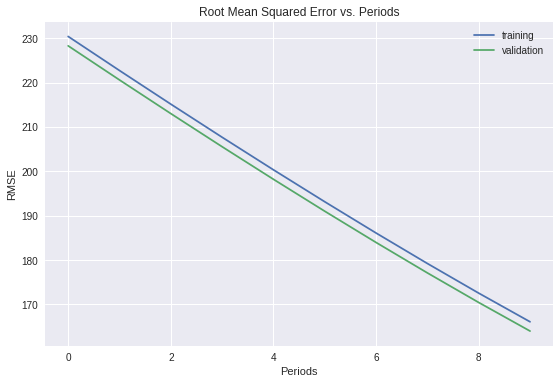

In [9]:
#
# Your code here: add your features of choice as a list of quoted strings.
#
minimal_features = [
    "median_income",
    "latitude",
    'rooms_per_person'
]

assert minimal_features, "You must select at least one feature!"

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

#
# Don't forget to adjust these parameters.
#
train_model(
    learning_rate=0.001,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

 ### Solution

Cliquez ci-dessous pour afficher une solution.

Training model...
RMSE (on training data):
  period 00 : 166.21
  period 01 : 127.40
  period 02 : 118.00
  period 03 : 116.33
  period 04 : 115.87
  period 05 : 115.11
  period 06 : 114.57
  period 07 : 113.86
  period 08 : 113.67
  period 09 : 112.98
Model training finished.


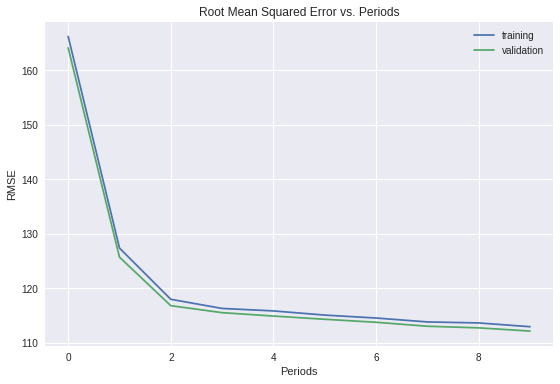

In [10]:
minimal_features = [
  "median_income",
  "latitude",
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

 ## Tâche 2 : Mieux exploiter la caractéristique Latitude

La représentation graphique des valeurs `latitude` par rapport à `median_house_value` montre qu'il n'y a pas vraiment de lien entre les deux.

On constate, en revanche, la présence de quelques pics qui correspondent approximativement à Los Angeles et San Francisco.

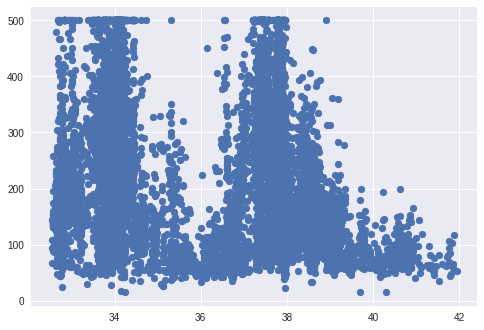

In [11]:
plt.scatter(training_examples["latitude"], training_targets["median_house_value"])

 **Essayez de créer quelques caractéristiques synthétiques qui offrent de meilleures performances avec la latitude.**

Vous pouvez, par exemple, créer une caractéristique qui associe `latitude` à la valeur `|latitude - 38|` et lui attribuer le nom `distance_from_san_francisco`.

Vous pouvez également diviser l'espace en 10 buckets (`latitude_32_to_33`, `latitude_33_to_34`, etc.) affichant chacun une valeur de `1.0` si `latitude` se situe dans cette plage de buckets et une valeur de `0.0` dans le cas contraire.

Utilisez la matrice de corrélation pour faciliter le développement et ajoutez ensuite les buckets à votre modèle si vous trouvez un élément satisfaisant.

Quelles sont les meilleures performances qu'il est possible d'obtenir en termes de validation ?

In [0]:
#
# YOUR CODE HERE: Train on a new data set that includes synthetic features based on latitude.
#
LATITUDE_RANGES = zip(range(32, 44), range(33, 45))

def select_and_transform_features(source_df):
  selected_examples = pd.DataFrame()
  selected_examples["median_income"] = source_df["median_income"]
  for r in LATITUDE_RANGES:
    selected_examples["latitude_%d_to_%d" % r] = source_df["latitude"].apply(
      lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
  return selected_examples

selected_training_examples = select_and_transform_features(training_examples)
selected_validation_examples = select_and_transform_features(validation_examples)

 ### Solution

Cliquez ci-dessous pour afficher une solution.

 Outre `latitude`, vous allez conserver la valeur `median_income` pour effectuer des comparaisons avec les résultats précédents.

Nous avons décidé d'effectuer un binning sur la latitude. C'est une opération relativement simple dans Pandas grâce à `Series.apply`.

In [0]:
def select_and_transform_features(source_df):
  LATITUDE_RANGES = zip(range(32, 44), range(33, 45))
  selected_examples = pd.DataFrame()
  selected_examples["median_income"] = source_df["median_income"]
  for r in LATITUDE_RANGES:
    selected_examples["latitude_%d_to_%d" % r] = source_df["latitude"].apply(
      lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
  return selected_examples

selected_training_examples = select_and_transform_features(training_examples)
selected_validation_examples = select_and_transform_features(validation_examples)

Training model...
RMSE (on training data):
  period 00 : 227.85
  period 01 : 217.60
  period 02 : 207.46
  period 03 : 197.41
  period 04 : 187.48
  period 05 : 177.68
  period 06 : 168.06
  period 07 : 158.62
  period 08 : 149.41
  period 09 : 140.51
Model training finished.


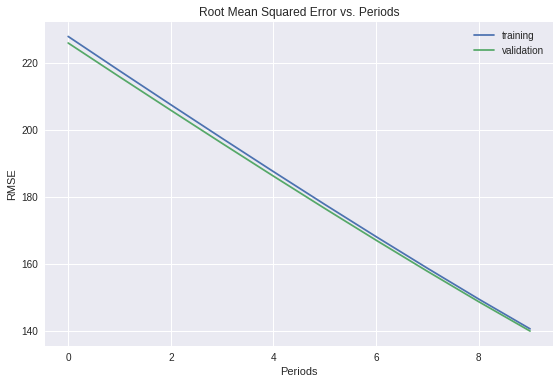

In [16]:
_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=selected_training_examples,
    training_targets=training_targets,
    validation_examples=selected_validation_examples,
    validation_targets=validation_targets)